# Modules

In [1]:
from lib import wrappers
from lib import dqn_model
import time
import numpy as np
import collections
import matplotlib as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter

# Constants

In [2]:
DEFAULT_ENV_NAMES = ["PongNoFrameskip-v4", "BreakoutNoFrameskip-v4"]
MEAN_REWARD_BOUND = 19.5
EPSILON_DECAY_LAST_FRAME = 10**5
EPSILON_START = 1.0
EPSILON_FINAL = 0.02
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

# Classes

Experienced Buffer

In [3]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)



Agent

In [6]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


# Loss Calculations

In [9]:
def calc_loss(batch, net, tgt_net, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states).to(device)
    next_states_v = torch.tensor(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.ByteTensor(dones).to(device)

    actions_v2 = actions_v.unsqueeze(-1).long()

    state_action_values = net(states_v).gather(1, actions_v2).squeeze(-1)
    
    next_state_values = tgt_net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

# Main

In [8]:

import matplotlib.pyplot as plt
# device = torch.device("gpu")
device = torch.device("cuda")

env = wrappers.make_env(DEFAULT_ENV_NAME)

net = dqn_model.DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = dqn_model.DQN(env.observation_space.shape, env.action_space.n).to(device)
writer = SummaryWriter(comment="-" + DEFAULT_ENV_NAME)
print(net)

buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_mean_reward = None

NUM_GAMES = 450

# for plots
mean_rewards = []
num_games = []
epsilons = []
frames = []


while len(total_rewards) < NUM_GAMES:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    if frame_idx % 100 == 0:
        epsilons.append(epsilon)
        frames.append(frame_idx)

    reward = agent.play_step(net, epsilon, device=device)
    if reward is not None:
    # if reward is not None and reward > 0:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        mean_reward = np.mean(total_rewards[-100:])
        mean_rewards.append(mean_reward)
        num_games.append(len(total_rewards))
        print("%d frames over %d games, mean reward %.3f, eps %.2f, speed %.2f f/s" % (
            frame_idx, len(total_rewards), mean_reward, epsilon,
            speed
        ))
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", mean_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)
        if best_mean_reward is None or best_mean_reward < mean_reward:
            torch.save(net.state_dict(), DEFAULT_ENV_NAME + "-best.dat")
            if best_mean_reward is not None:
                print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
            best_mean_reward = mean_reward
        if mean_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break

    if len(buffer) < REPLAY_START_SIZE:
        continue

    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()

writer.close()

plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()


NameError: name 'DEFAULT_ENV_NAME' is not defined

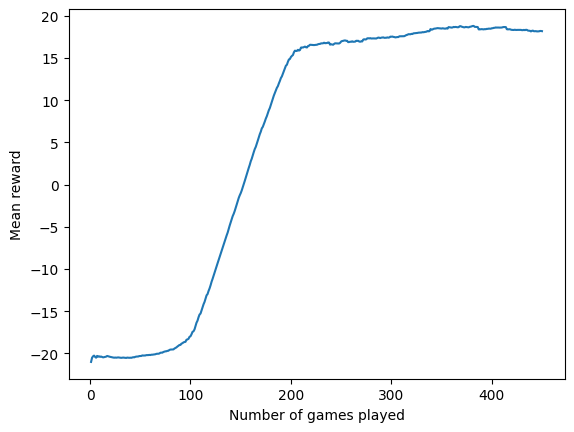

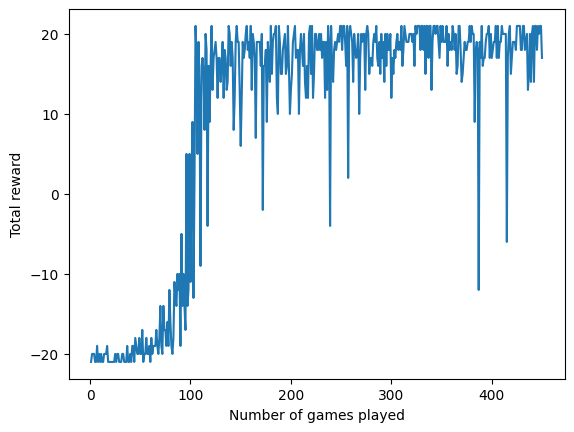

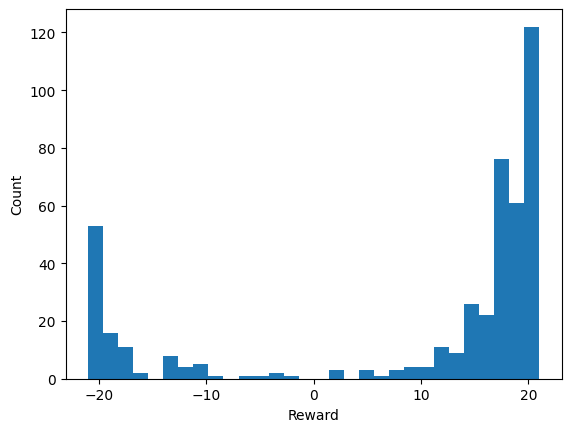

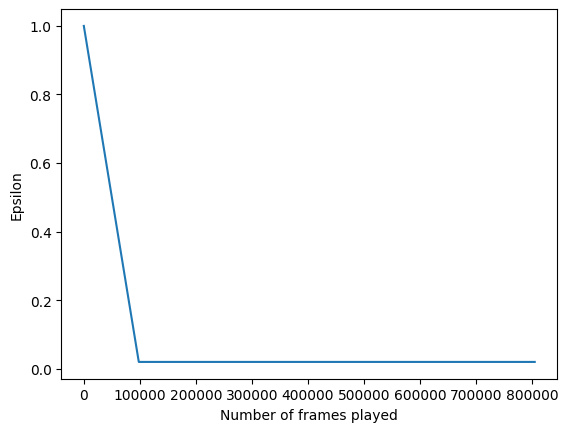

In [50]:
import matplotlib.pyplot as plt
plt.plot(num_games, mean_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Mean reward')
plt.show()

plt.plot(range(1, len(total_rewards)+1), total_rewards)
plt.xlabel('Number of games played')
plt.ylabel('Total reward')
plt.show()

plt.hist(total_rewards, bins=30)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show()

plt.plot(frames, epsilons)
plt.xlabel('Number of frames played')
plt.ylabel('Epsilon')
plt.show()